<a href="https://colab.research.google.com/github/CarolinaOliveira001/Complex_Network/blob/main/Assignment9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import files
uploaded = files.upload()

Saving 414.edges to 414 (1).edges


Here are the imports to solve the following the exercise.

In [13]:
import networkx as nx
from random import sample
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, accuracy_score
import matplotlib.pyplot as plt

We create two graph from the Facebook ego. We named them graphFacebook and trueGraphFacebook. The latter one will stay the same the whole exercise, however graphFacebook will take some changes.

In [14]:
filenameFacebook = "414.edges"

graphFacebook = nx.Graph()
trueGraphFacebook = nx.Graph()

with open(filenameFacebook) as f:
    for line in f:
        x = line.split()
        a = int(x[0])
        b = int(x[1])
        
        if a not in list(graphFacebook.nodes):
            graphFacebook.add_node(a)
            trueGraphFacebook.add_node(a)
        if b not in list(graphFacebook.nodes):
            graphFacebook.add_node(b)
            trueGraphFacebook.add_node(b)

        graphFacebook.add_edge(a, b)
        trueGraphFacebook.add_edge(a, b)

First we pick 10% of the edges to delete them from the graphFacebook. The edges will be picked randomly. Then we save the edges of the graphFacebook in a list called graphFacebookWithoutRemovedEdges.

In [15]:
random_edges = set(sample(list(graphFacebook.edges()), int(round(graphFacebook.number_of_edges()*10/100, 0))))

In [16]:
for edge in random_edges:
  graphFacebook.remove_edge(edge[0], edge[1])

In [17]:
graphFacebookWithoutRemovedEdges = list(graphFacebook.edges())

We chose the Adamic-Adar index algorithm to predict the deleted edges. Then we save the predicted edge with the corresponding index in a list. We sort this list by the index in a descending order. We can now get the highest index and we divide each index in the list to get the probability.

In [18]:
predictedModel = nx.adamic_adar_index(graphFacebook)

In [19]:
listOfPredictedEdges = []

for u, v, p in predictedModel:
    listOfPredictedEdges.append((u, v, p))

In [20]:
listOfPredictedEdges = sorted(listOfPredictedEdges, key=lambda tup: tup[2], reverse=True)

In [21]:
highestAdamicAdarModel = listOfPredictedEdges[0][2]

In [22]:
listOfProbabilityEdges = []

for (a, b, p) in listOfPredictedEdges:
  listOfProbabilityEdges.append([(a, b), p/highestAdamicAdarModel])

Since we need to account also the non-edges predicted, we decided to create a complete graph with a list of node from the trueGraphFacebook. From the complete graph, we get all the possible edges between the nodes and substract the one from the graphFacebook. The list of of the previous edges will the all the possible to predicted edges from the model.

In [23]:
completetrueGraphFacebook = nx.complete_graph(trueGraphFacebook.nodes())

In [24]:
listOfAllPossibleEdges = list(completetrueGraphFacebook.edges())

In [25]:
for edge in graphFacebookWithoutRemovedEdges:
  listOfAllPossibleEdges.remove(edge)

We will only look at the edges which the model can predict.
First we create a list of 1 if the edge at a specific position in the listOfAllPossibleEdges is also in the list of edges from the trueGraphFacebook.

In [26]:
listOfTrueGraphFacebooksEdges = []

for edge in listOfAllPossibleEdges:
  if edge in list(trueGraphFacebook.edges()):
    listOfTrueGraphFacebooksEdges.append(1)
  else:
    listOfTrueGraphFacebooksEdges.append(0)

We create a listOfProbabilityGraphFacebooksEdges which has the probability given by the model at their specific position in the listOfAllPossibleEdges. If this edges is not in the listOfProbabilityEdges, then we will put 0 as the probability.

In [27]:
listOfProbabilityGraphFacebooksEdges = []

for edgeA in listOfAllPossibleEdges:
  valueHelper = []
  for idx in range(0, len(listOfProbabilityEdges)):
    edgeB = listOfProbabilityEdges[idx][0]
    if edgeA == edgeB:
      valueHelper.append(listOfProbabilityEdges[idx][1])
    
  if len(valueHelper) == 0:
    listOfProbabilityGraphFacebooksEdges.append(0)
  else:
    listOfProbabilityGraphFacebooksEdges.append(valueHelper[0])

The listOfGraphFacebooksEdges will have either 0 or 1 at each entry. It will be 1 if the probability of the predict edge by the model is bigger than 0.5 and 0 otherwise.

In [28]:
listOfGraphFacebooksEdges = []

for edgeA in listOfAllPossibleEdges:
  valueHelper = []
  for idx in range(0, len(listOfProbabilityEdges)):
    edgeB = listOfProbabilityEdges[idx][0]
    if edgeA == edgeB:
      if listOfProbabilityEdges[idx][1] > 0.5:
        valueHelper.append(1)
      else:
        valueHelper.append(0)
  
  if(len(valueHelper) == 0):
    listOfGraphFacebooksEdges.append(0)
  else:
    listOfGraphFacebooksEdges.append(valueHelper[0])

Precision

We calculate the precision between listOfTrueGraphFacebookEdges and listOfGraphFacebookEdges.

In [29]:
precision = precision_score(listOfTrueGraphFacebooksEdges, listOfGraphFacebooksEdges)

In [30]:
print(f'Precision: {precision}')

Precision: 0.3888888888888889


Accuracy

We calculate the accuracy between listOfTrueGraphFacebookEdges and listOfGraphFacebookEdges.

In [31]:
accuracy = accuracy_score(listOfTrueGraphFacebooksEdges, listOfGraphFacebooksEdges)

In [32]:
print(f'Accuracy: {accuracy}')

Accuracy: 0.9795876075018133


ROC

We calculate the ROC curve between the listOfTrueGraphFacebooksEdges and listOfProbabilityGraphFacebooksEdges. At the end we plot it.

In [33]:
complementOfSpecificity, sensitivity, __ = roc_curve(listOfTrueGraphFacebooksEdges, listOfProbabilityGraphFacebooksEdges)

In [34]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

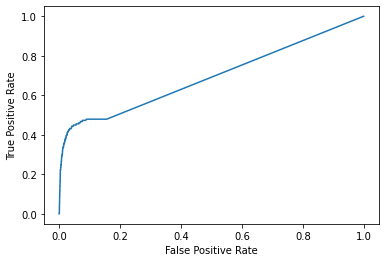

In [35]:
plot_roc_curve(complementOfSpecificity, sensitivity)

AUROC

We also calculate the area under the ROC curve and this is the output.

In [36]:
print(f'AUC score: {roc_auc_score(listOfTrueGraphFacebooksEdges, listOfProbabilityGraphFacebooksEdges)}')

AUC score: 0.692911764302091
